In [1]:
import os
import numpy as np
import cv2 as cv
import joblib
import json
from matplotlib import pyplot as plt
import sklearn.svm as svm
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils import shuffle
import glob
import sklearn
from gx_spectral.feature import roi, spectrum
import spectral
from skimage.feature import graycomatrix, graycoprops
from scipy.signal import savgol_filter      # filter


plt.rcParams['figure.max_open_warning'] = 0      # Turn off warning

# Font configuration
plt.rcParams['font.family'] = 'Noto Serif SC'
"""Check fonts in matplotlib
from matplotlib import font_manager
for font in font_manager.fontManager.ttflist:
    print(font.name, '-', font.name)
"""


"Check fonts in matplotlib\nfrom matplotlib import font_manager\nfor font in font_manager.fontManager.ttflist:\n    print(font.name, '-', font.name)\n"

## 一、取得训练数据
1. 从文档中提取图片，图片按照文件夹被分类
2. 将四个通道合成多光谱图像
3. 阈值分割，取得感兴趣的区域（咖啡豆），得到图像 `mask`
4. 在 `mask` 上寻找轮廓（contours），得到目标掩膜（`target_mask`）
5. 利用掩膜，从原始多光谱图像中提取该区域的多光谱均值（即特征），并记录对应的类别
其中 `msi[target_mask]` 会返回这个掩膜中 `True` 的所有像素点在多光谱图像中的值
6. 取得该区域在 4 个通道上的平均值，用作该目标的光谱特征。

同时计算每颗咖啡豆的 GLCM 信息，存储于 `glcm_features`，一共是 80 * 288 的 NumPy 数组

其中 80 粒咖啡豆；4 通道 * 3 distances * 4 angles * 6 properties = 288

D:\Work_Dr\Coffee_bean\Source\coe4\GVM_20250326115336189_REF_450.tif
D:\Work_Dr\Coffee_bean\Source\coe4\GVM_20250326115336189_REF_555.tif
D:\Work_Dr\Coffee_bean\Source\coe4\GVM_20250326115336189_REF_660.tif
D:\Work_Dr\Coffee_bean\Source\coe4\GVM_20250326115336189_REF_850.tif
D:\Work_Dr\Coffee_bean\Source\coe6\GVM_20250326113945947_REF_450.tif
D:\Work_Dr\Coffee_bean\Source\coe6\GVM_20250326113945947_REF_555.tif
D:\Work_Dr\Coffee_bean\Source\coe6\GVM_20250326113945947_REF_660.tif
D:\Work_Dr\Coffee_bean\Source\coe6\GVM_20250326113945947_REF_850.tif
(80, 4) (80,)
(80, 288)


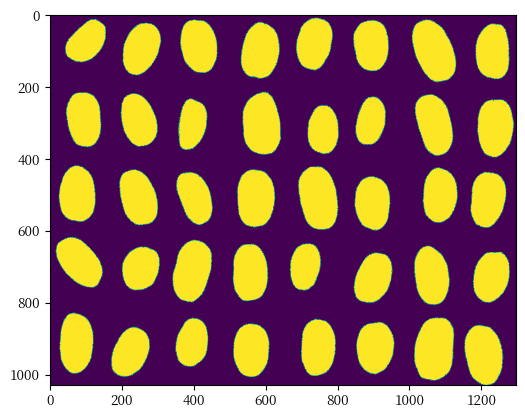

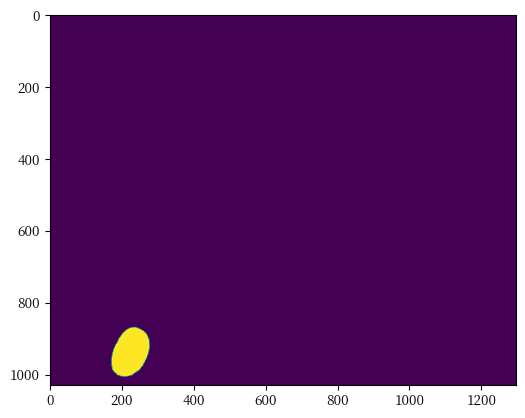

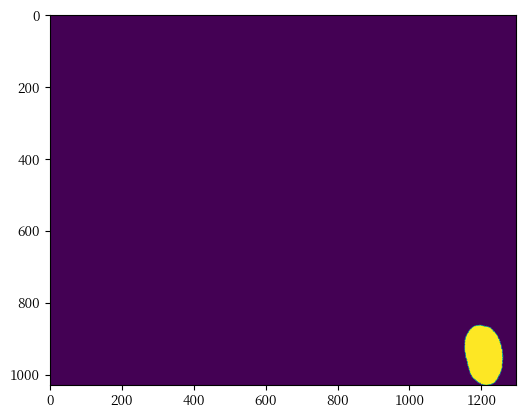

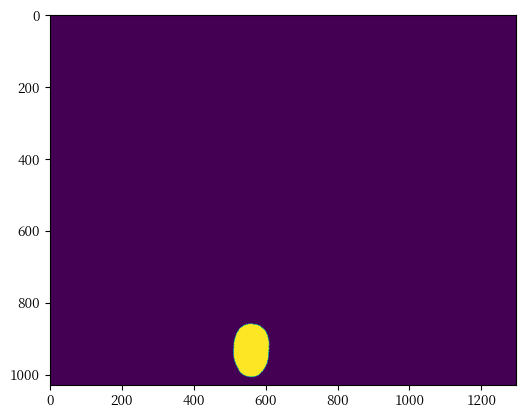

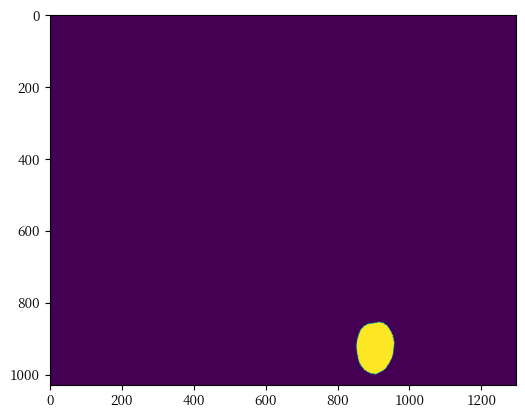

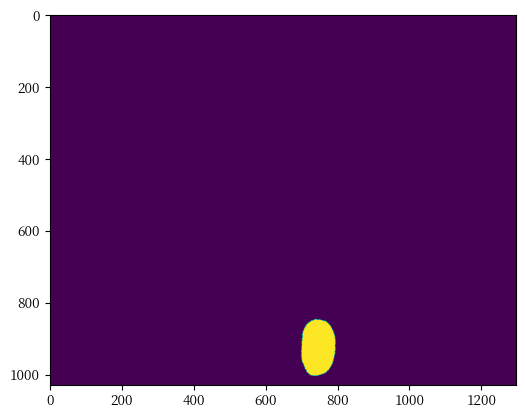

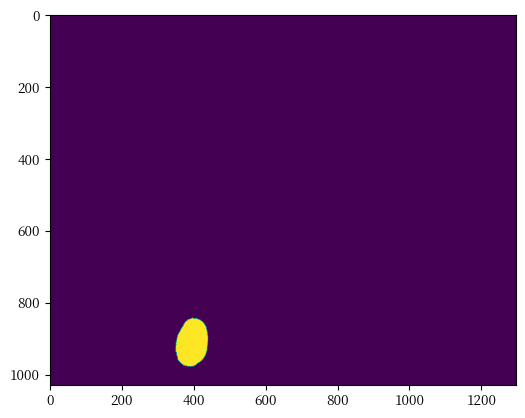

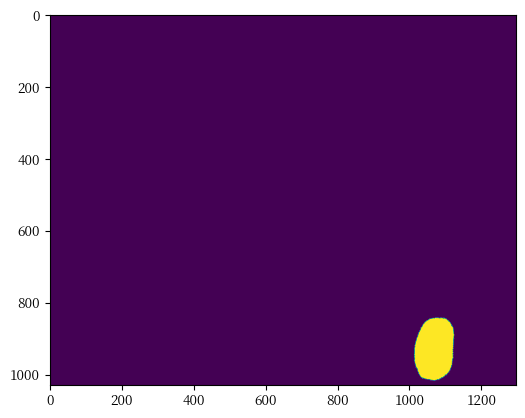

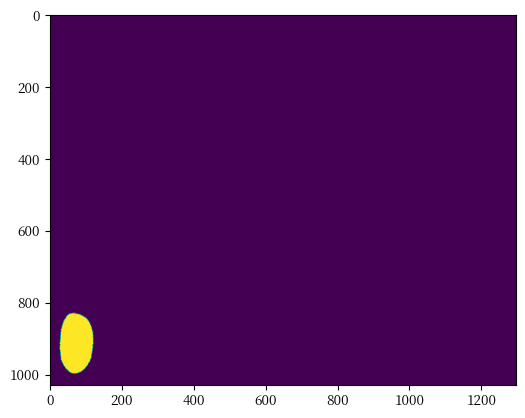

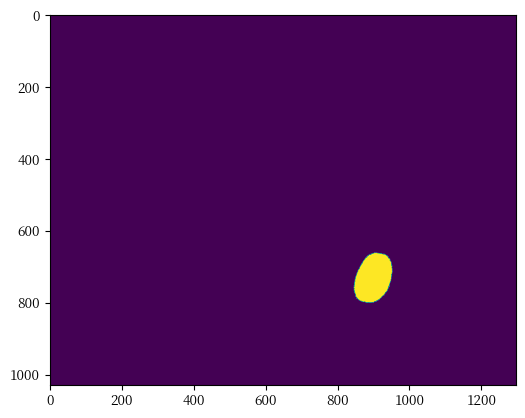

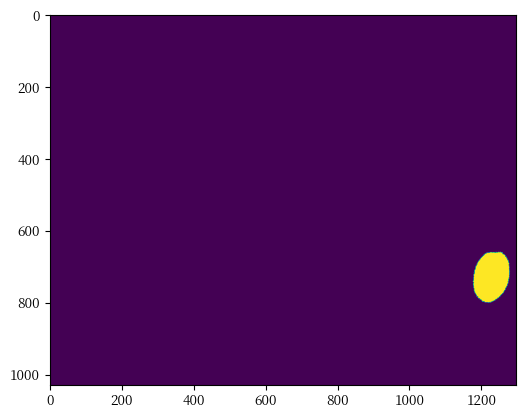

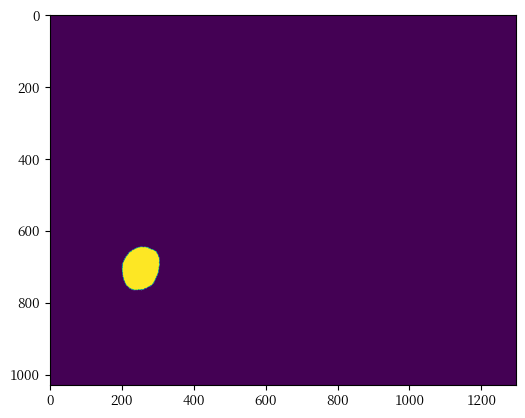

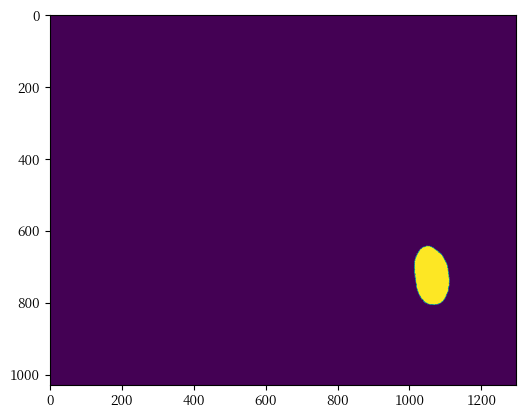

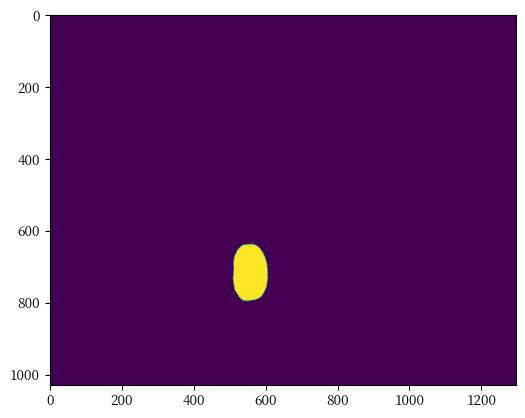

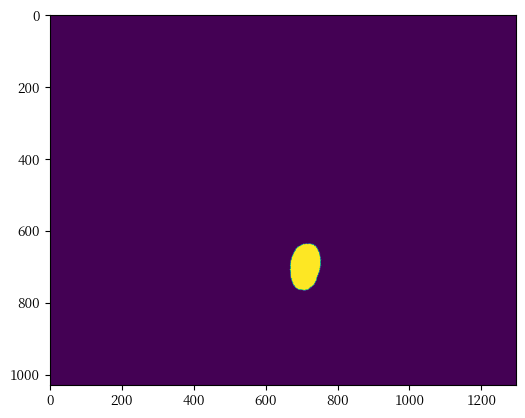

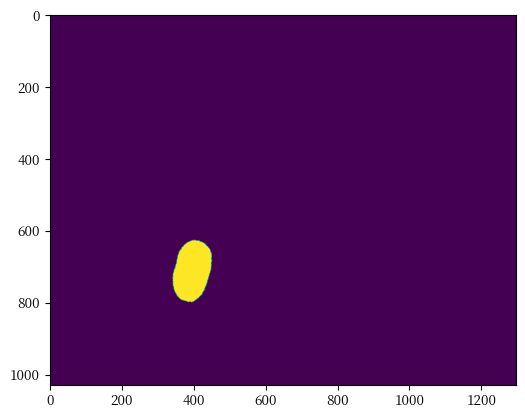

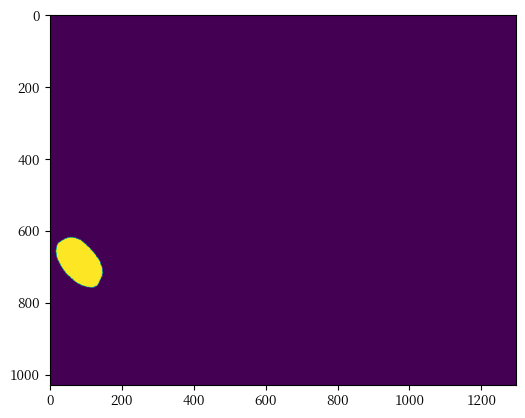

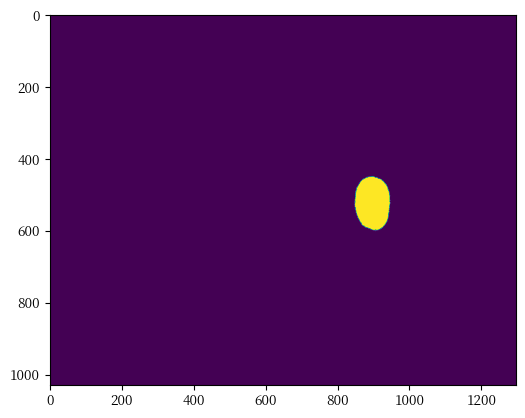

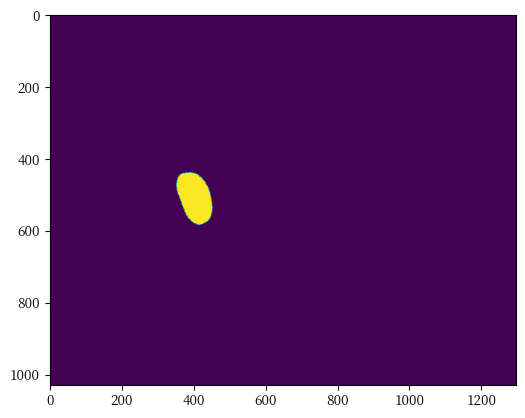

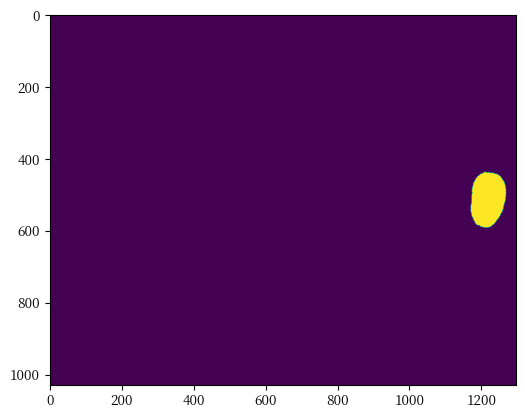

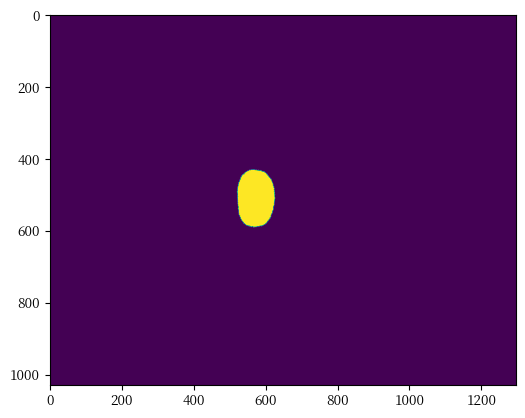

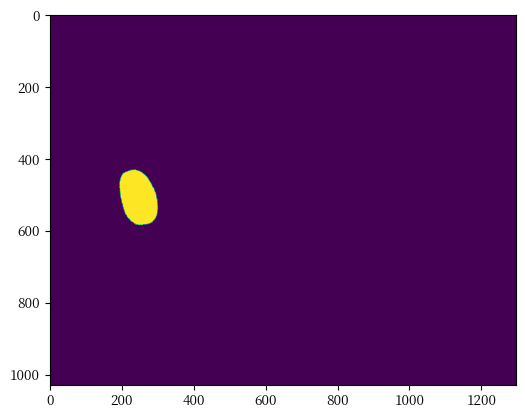

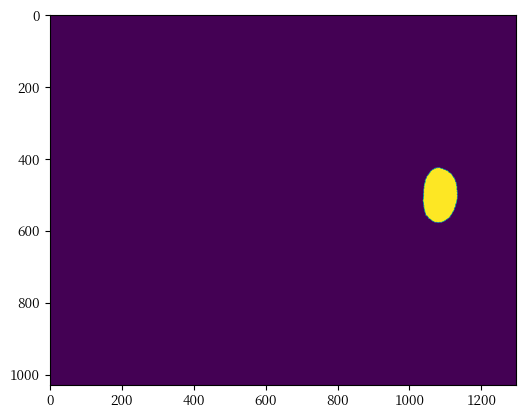

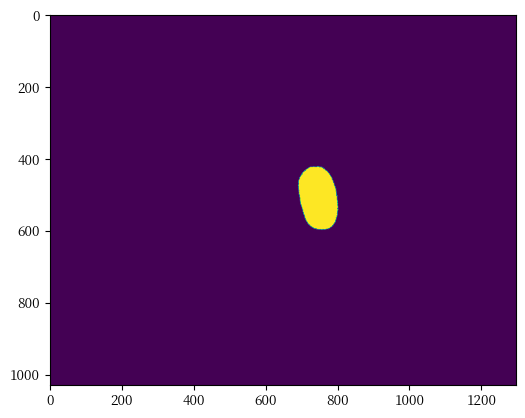

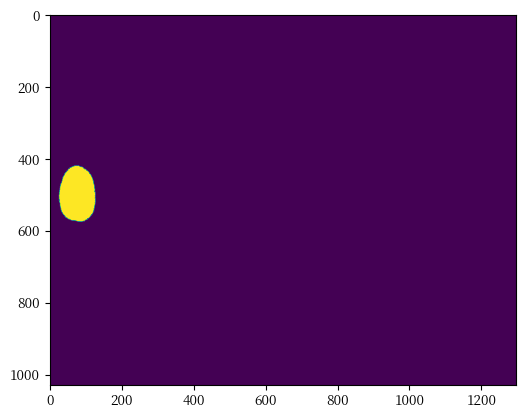

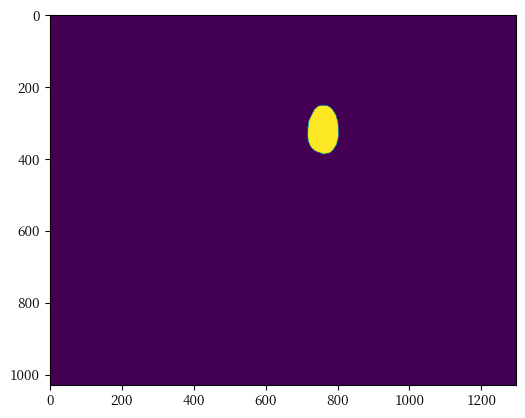

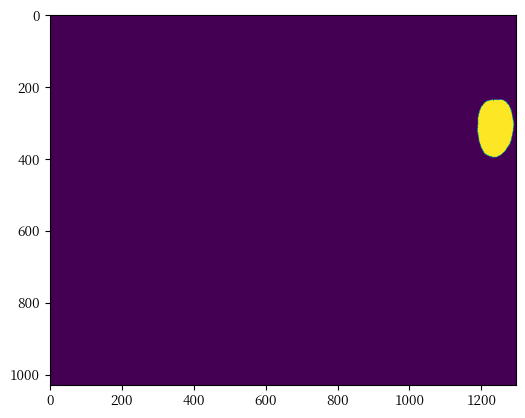

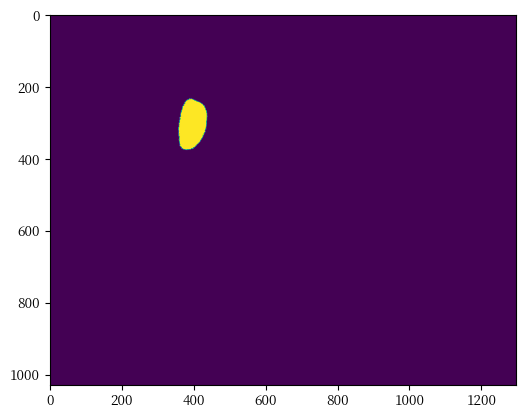

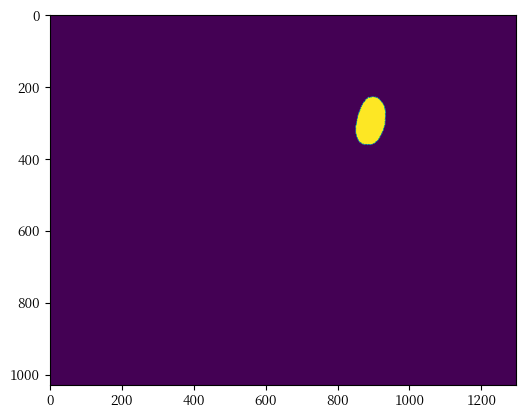

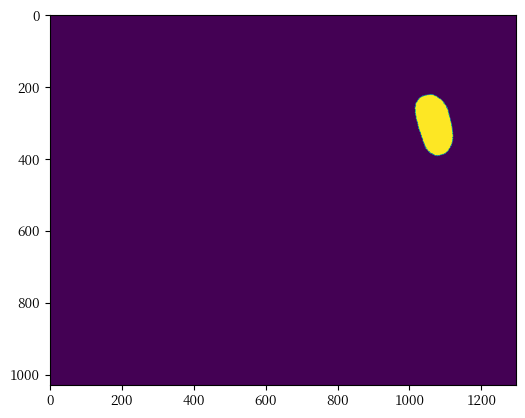

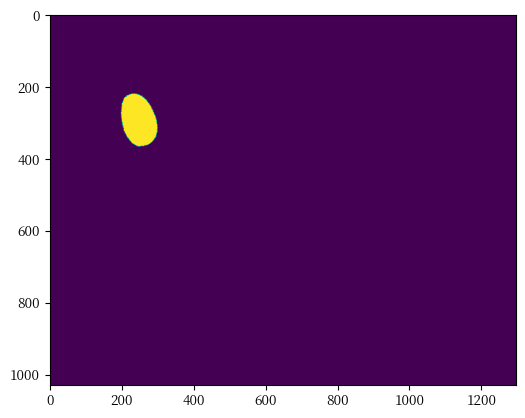

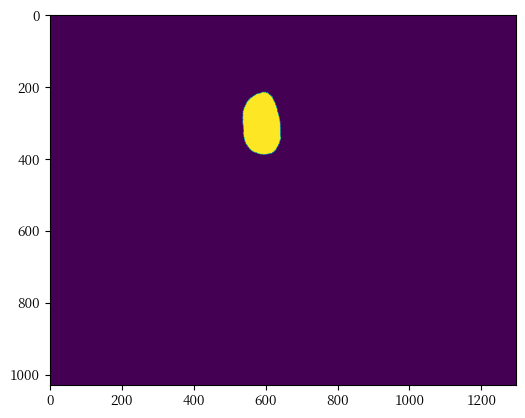

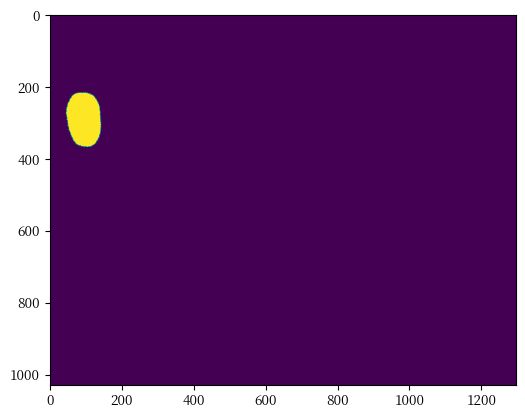

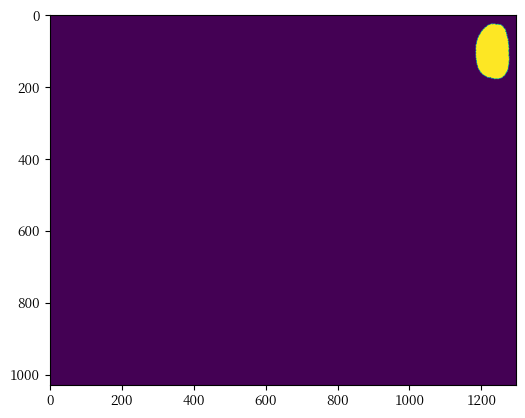

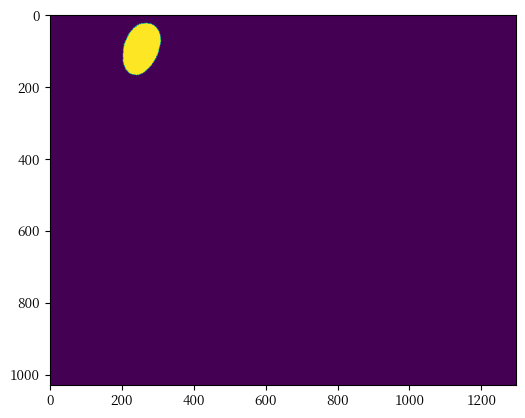

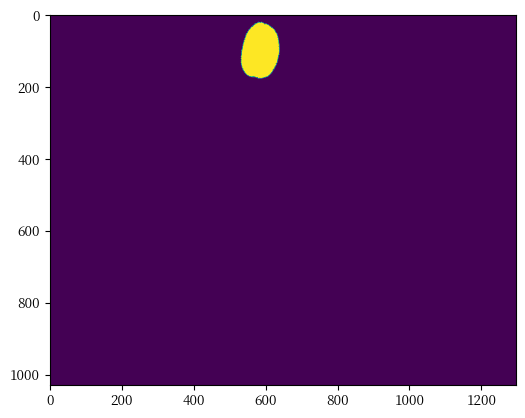

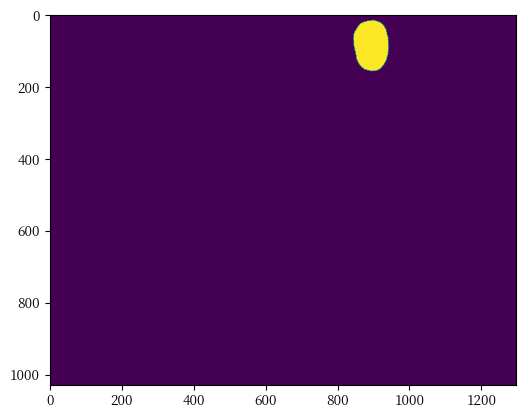

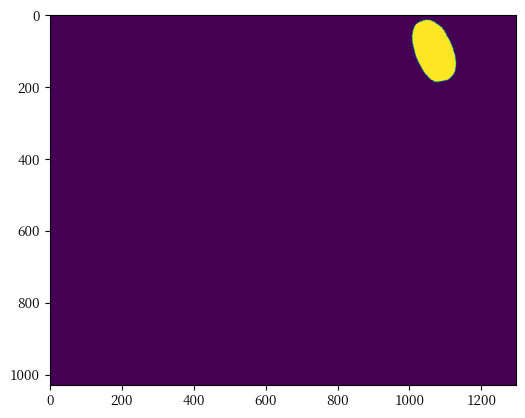

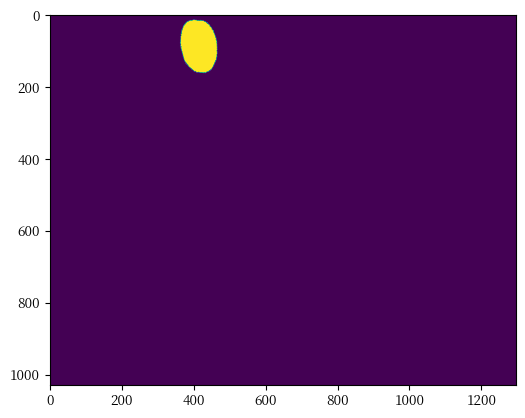

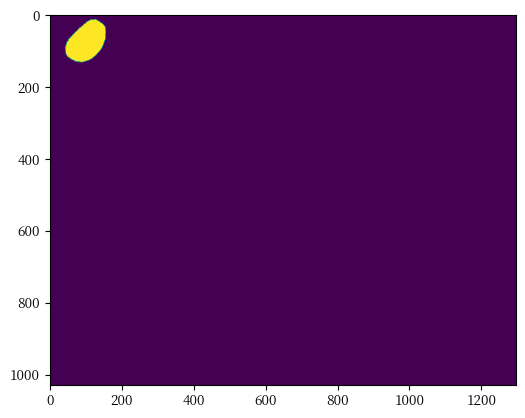

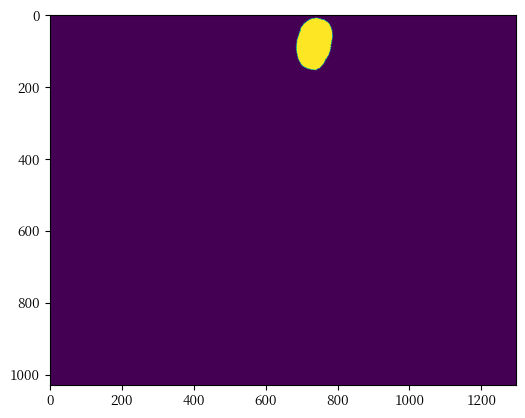

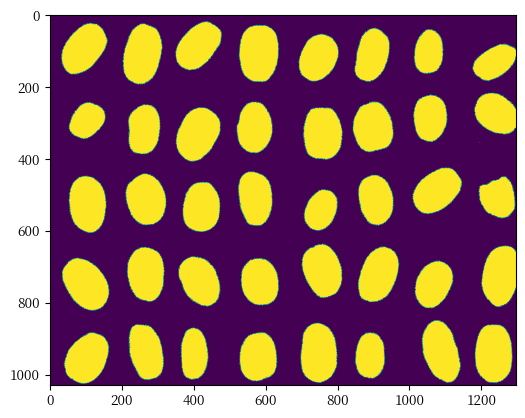

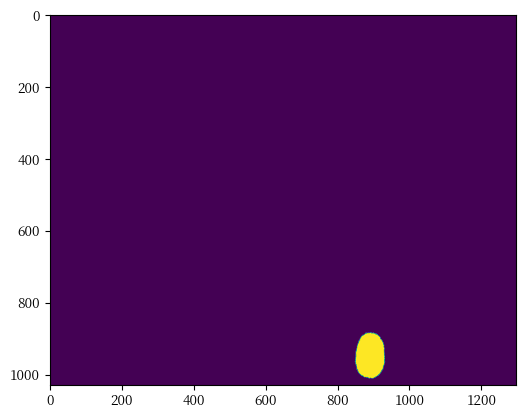

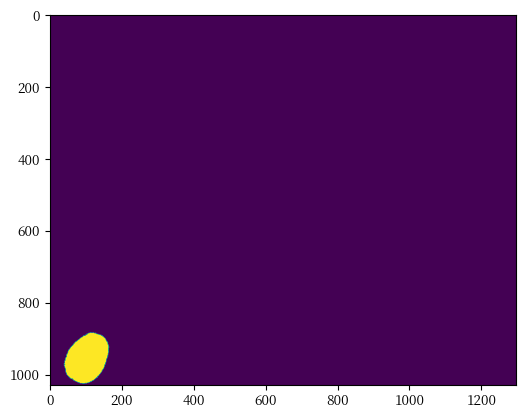

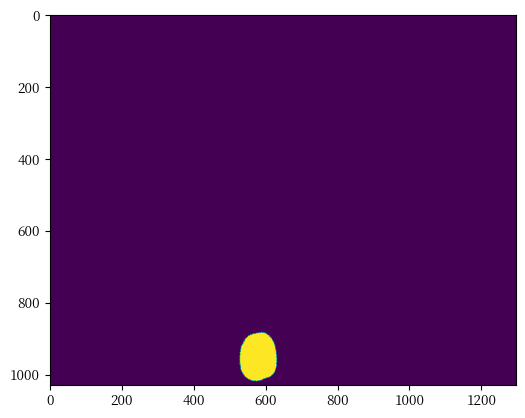

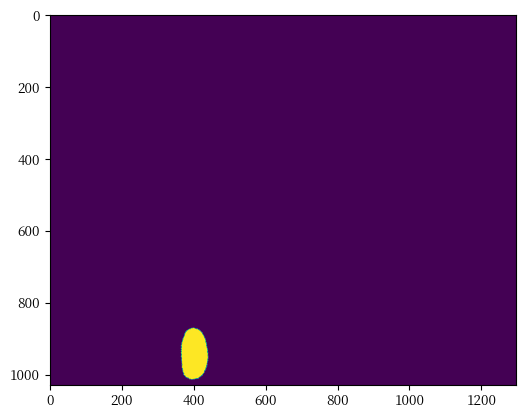

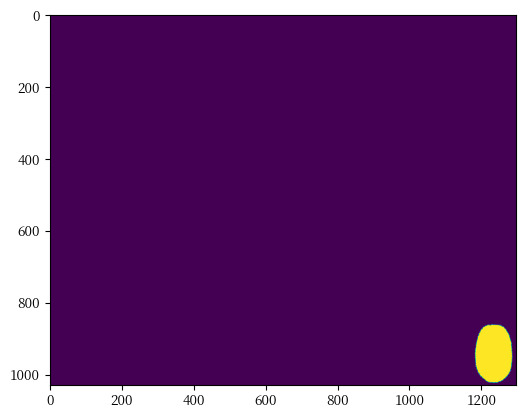

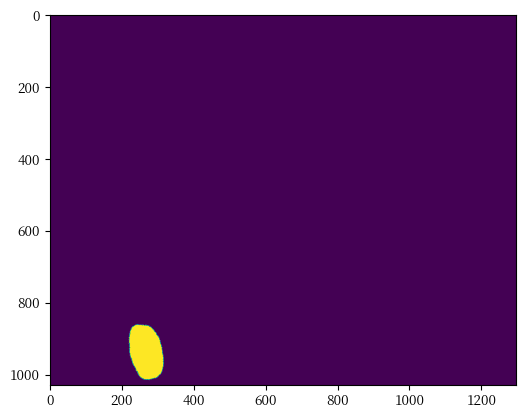

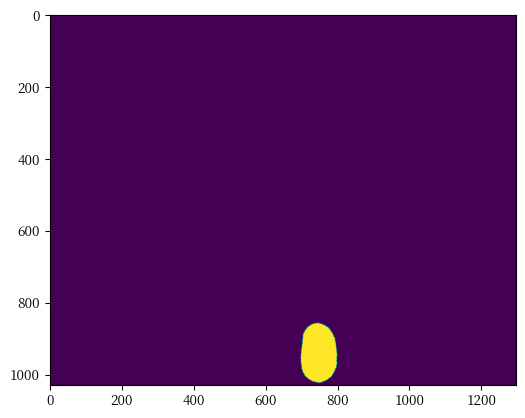

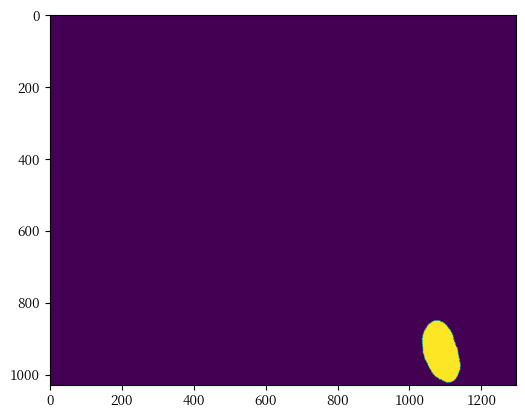

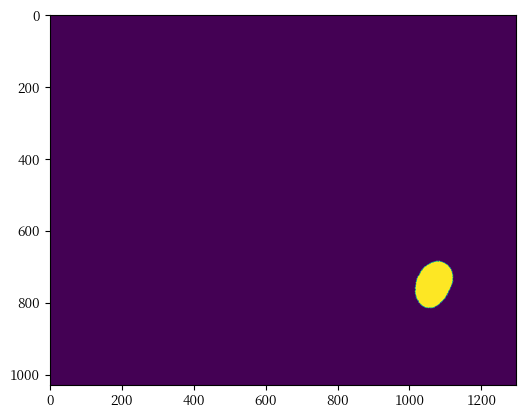

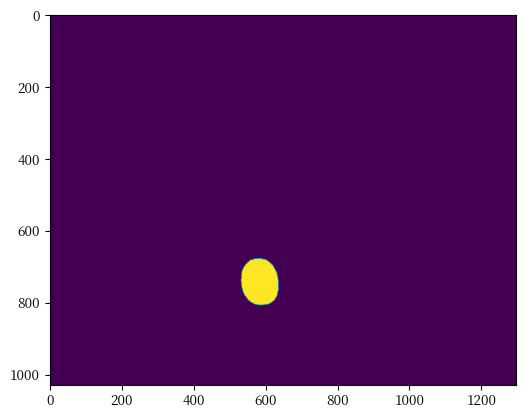

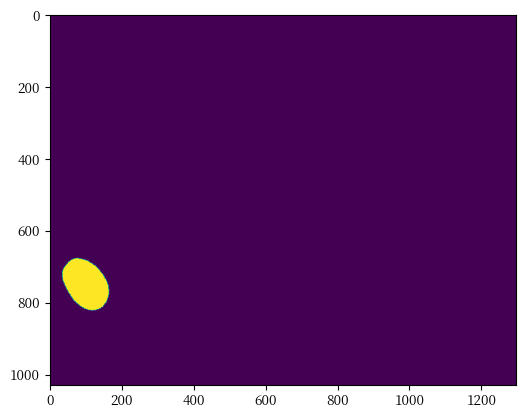

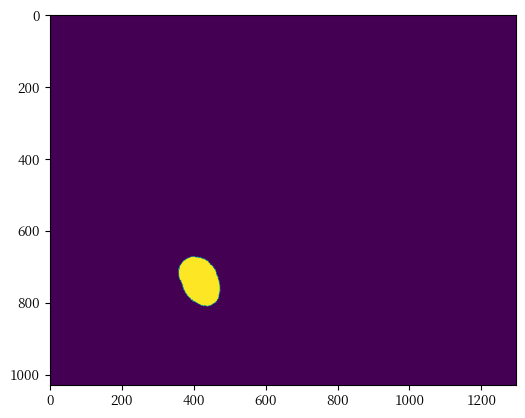

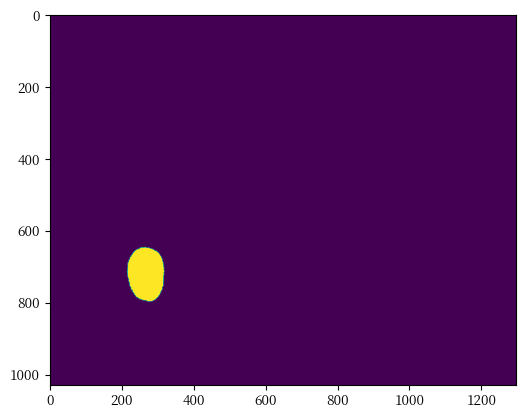

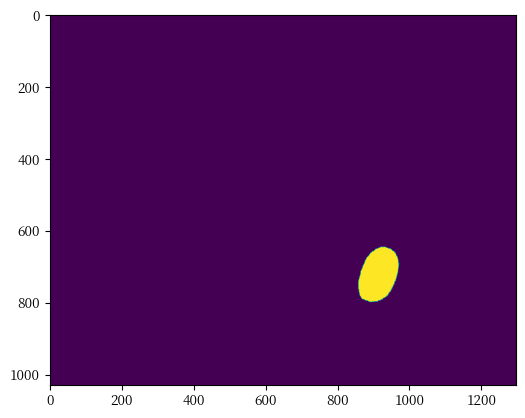

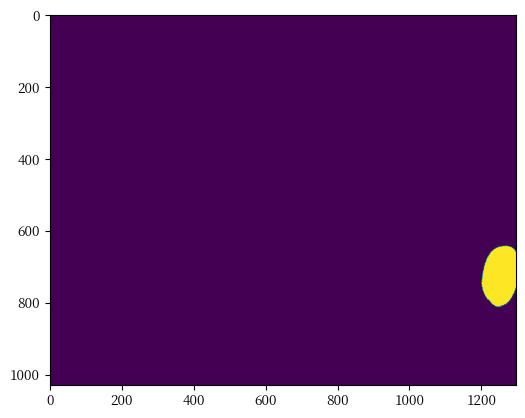

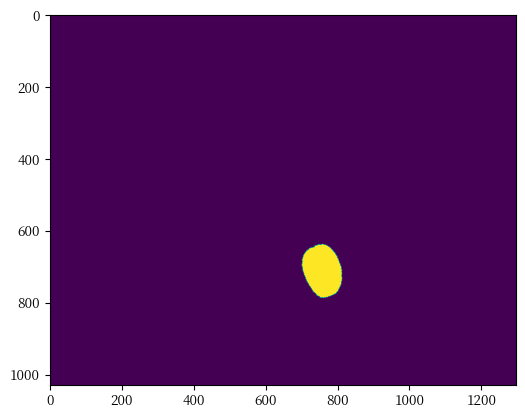

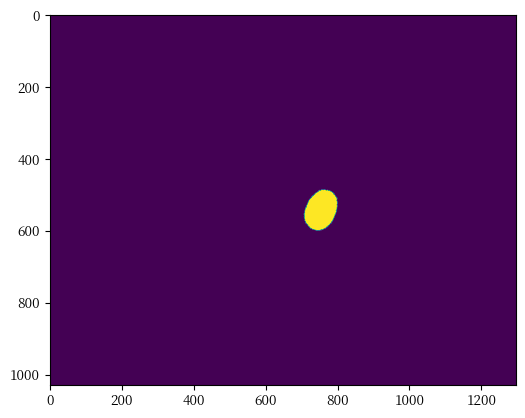

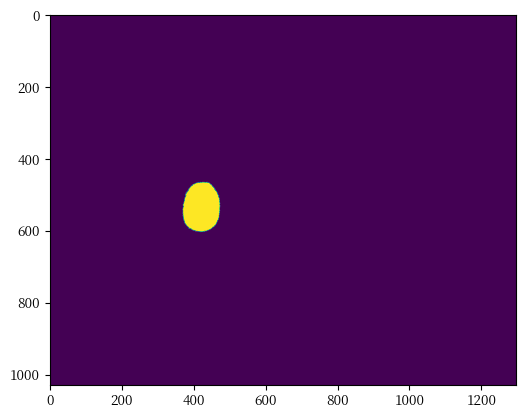

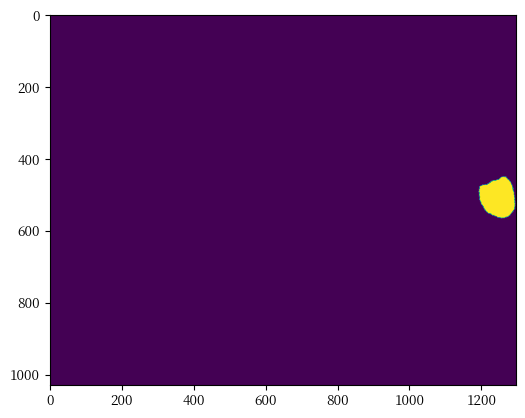

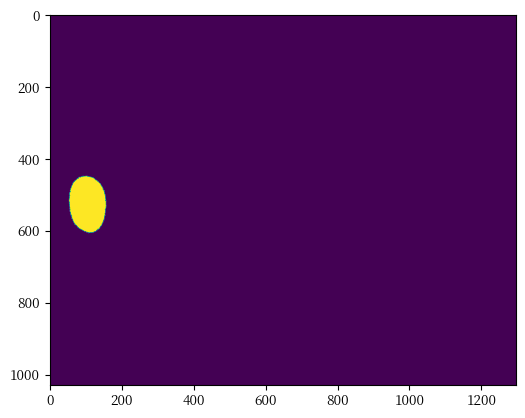

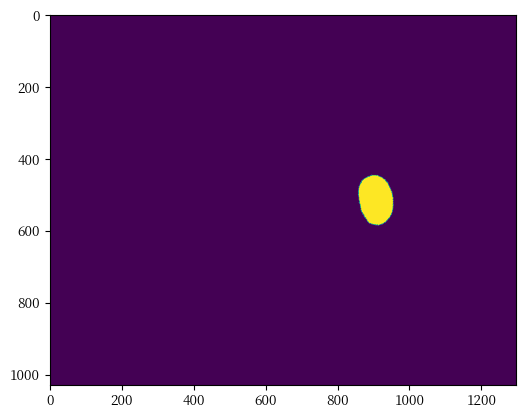

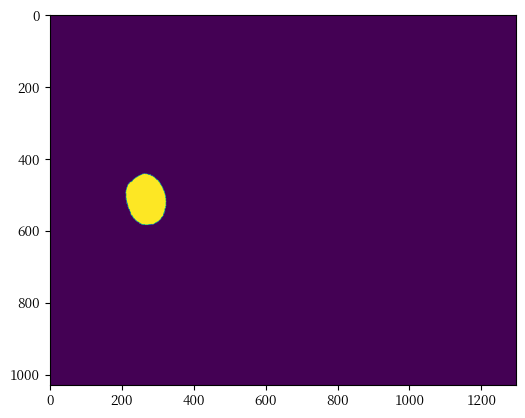

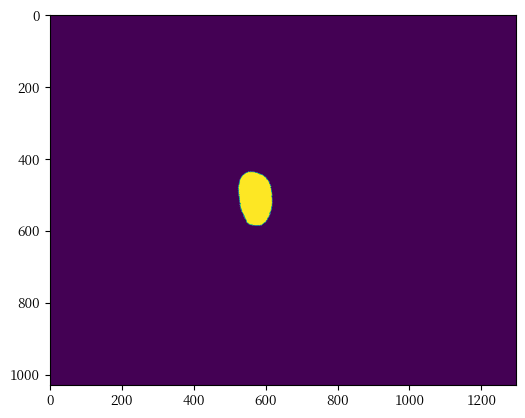

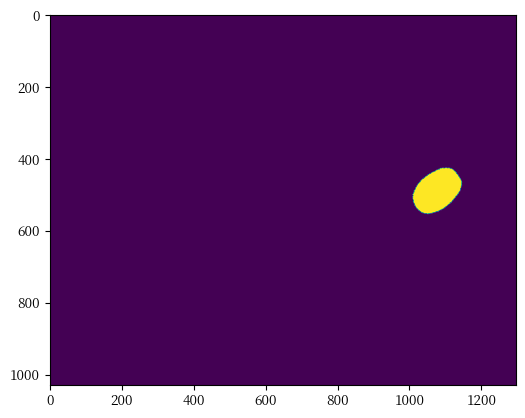

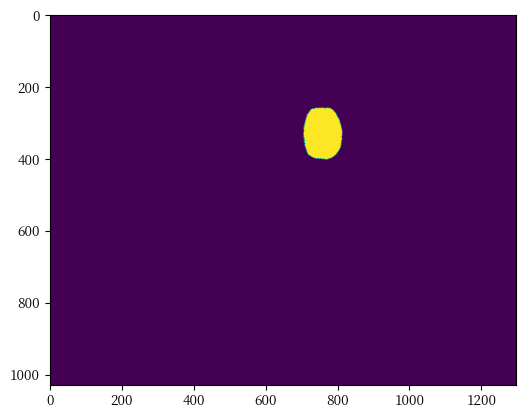

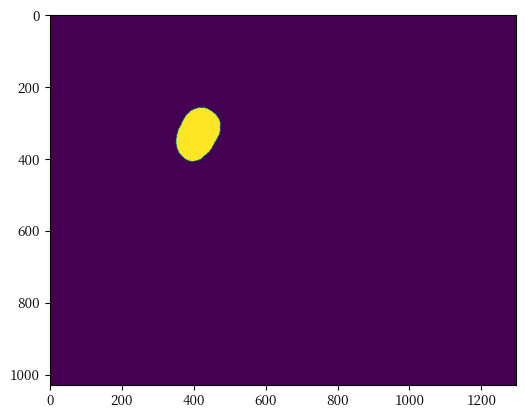

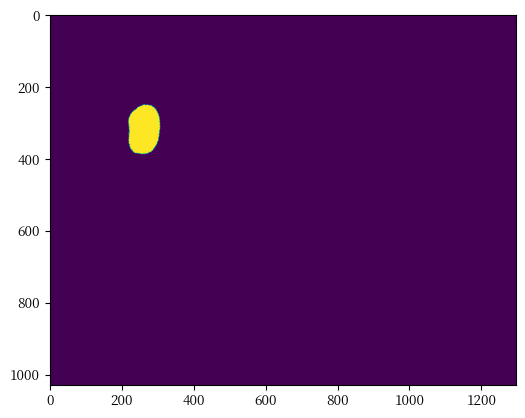

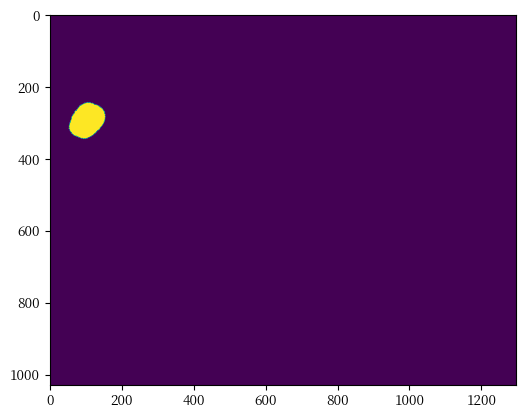

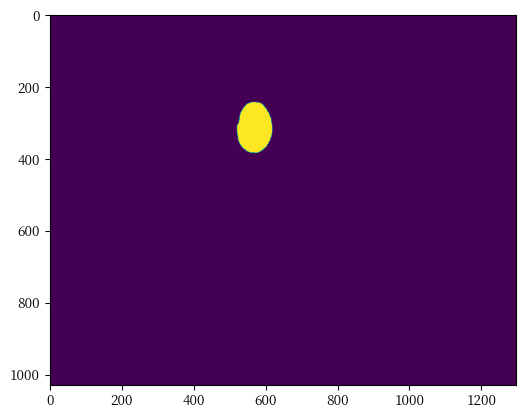

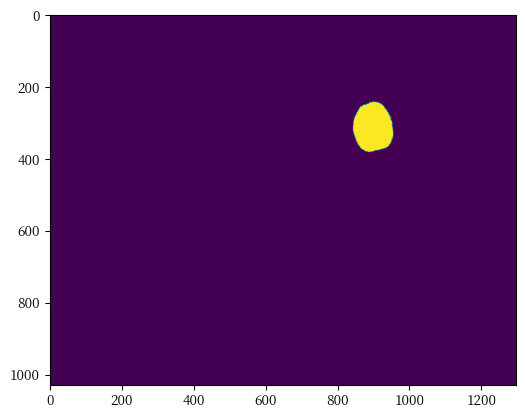

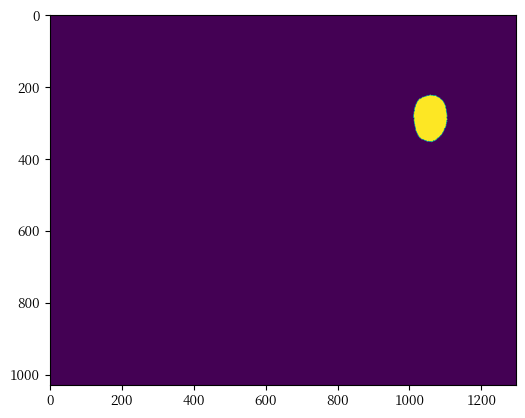

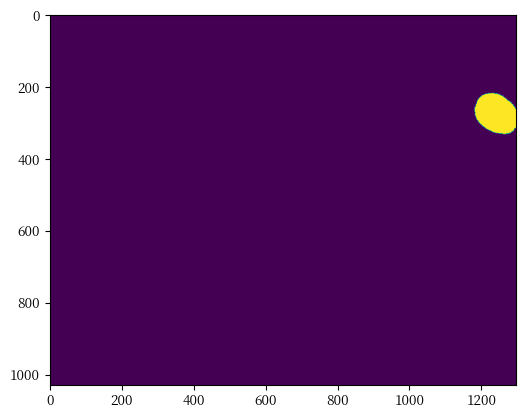

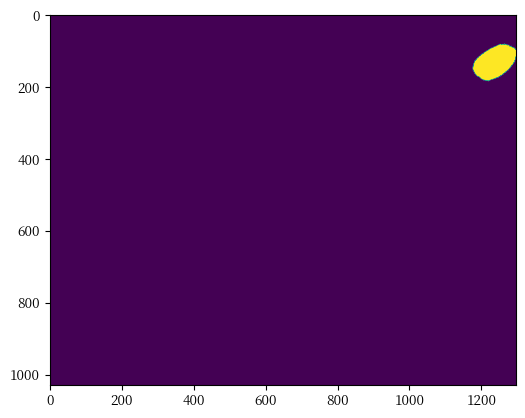

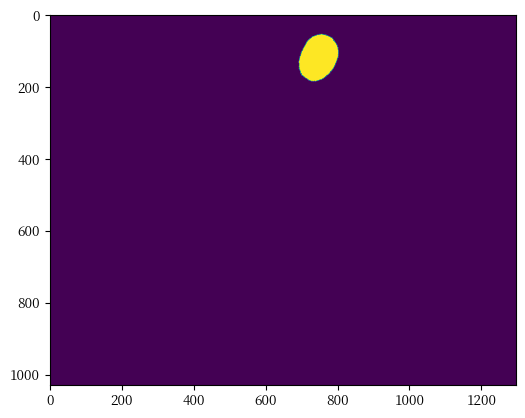

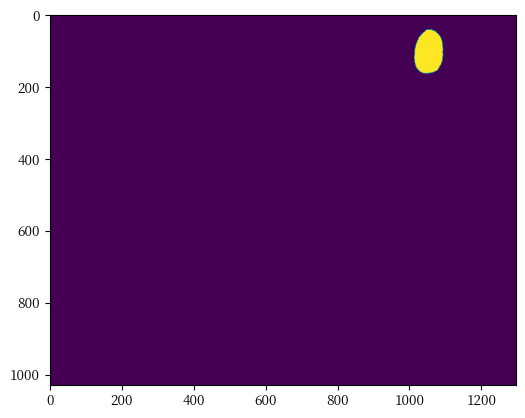

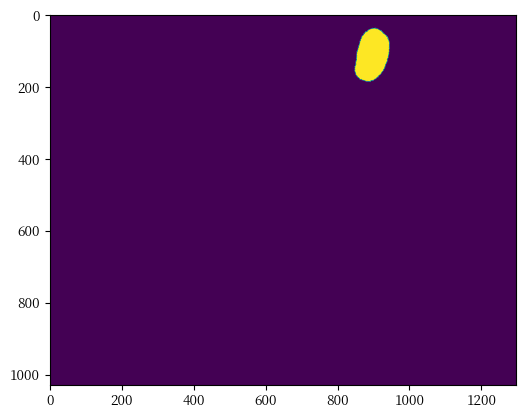

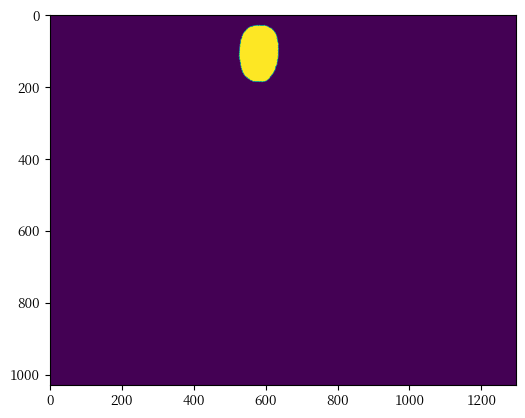

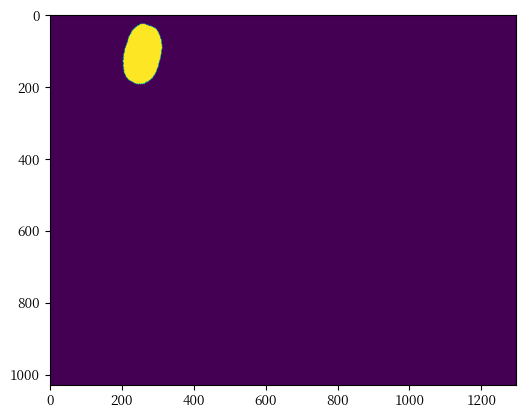

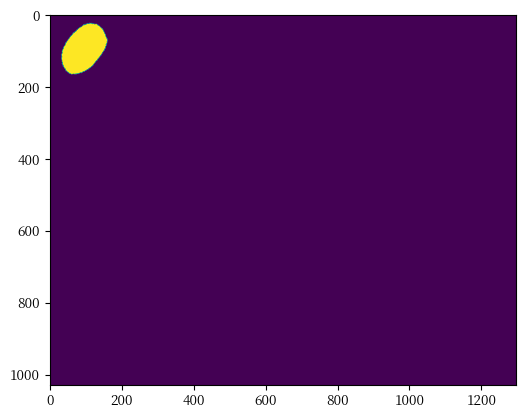

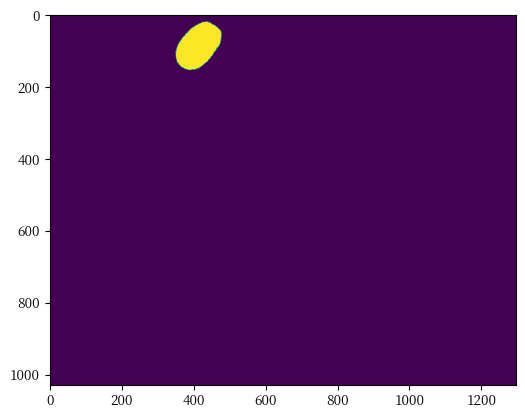

In [2]:
data_root = r'D:\Work_Dr\Coffee_bean\Source'
classes = os.listdir(data_root)



# 保存光谱数据与其对应标签
specs = []
sg_specs = []
snv_specs = []
FD_specs = []
SD_specs = []
labels = []

glcm_features = []

# GLCM 参数
distances = [1, 3, 5]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']

for cls in classes:
    cls_path = os.path.join(data_root, cls)
    img_names = sorted(os.listdir(cls_path))
    # Save MSI (Multiple Spectrum Image)
    msi = []
    for name in img_names:
        img_path = os.path.join(cls_path, name)
        print(img_path)
        img = cv.imread(img_path, cv.IMREAD_UNCHANGED)
        # Blend 4 channels into MSI
        msi.append(img)
    msi = np.transpose(np.array(msi), (1, 2, 0))
    # 使用 MSI 的第四通道用于阈值分割
    im_seg = msi[:, :, 3]
    im_seg = (im_seg / im_seg.max() * 255).astype(np.uint8)     # idk
    # 二值化图像，用于提取轮廓
    mask = cv.threshold(im_seg, 100, 255, cv.THRESH_BINARY)[1]
    # 展示咖啡豆轮廓
    plt.figure()
    plt.imshow(mask)
    # 寻找咖啡豆轮廓
    contours, hierarchy = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    for cont in contours:
        target_mask = np.zeros_like(im_seg)
        perimeter = cv.arcLength(cont, True)
        if perimeter < 50:
            # Skip if area is too small
            continue
        cv.drawContours(target_mask, [cont], 0, (255, 255, 255), -1)
        plt.figure()
        plt.imshow(target_mask)
        # 将目标区域的掩膜转换为布尔类型（True 表示目标区域，False 表示背景）
        target_mask = target_mask.astype(bool)
        # 取得该区域在 4 个通道上的平均光谱值
        spec = np.mean(msi[target_mask], axis=(0))
        specs.append(spec)
        labels.append(cls)

        # Calculate GLCM
        glcm_feats = []
        for channel in range(4):
            # 提取单个通道图像
            img_channel = msi[:, :, channel]
            
            # 应用掩码并转换为8位灰度图像
            masked_img = np.zeros_like(img_channel)
            masked_img[target_mask] = img_channel[target_mask]
            masked_img = (masked_img / masked_img.max() * 255).astype(np.uint8)

            # 获取包含咖啡豆的最小矩形区域（减少计算量）
            rows, cols = np.where(target_mask)
            if len(rows) == 0 or len(cols) == 0:
                continue

            min_row, max_row = np.min(rows), np.max(rows)
            min_col, max_col = np.min(cols), np.max(cols)
            roi = masked_img[min_row:max_row+1, min_col:max_col+1]

            # 计算GLCM矩阵
            glcm = graycomatrix(roi, distances=distances, angles=angles,
                               levels=256, symmetric=True, normed=True)

            # 提取GLCM属性
            for prop in properties:
                feature = graycoprops(glcm, prop).flatten()
                glcm_feats.extend(feature)

        # 添加GLCM特征到列表中
        glcm_features.append(np.array(glcm_feats))

        # break     # 取消注释以单词计算

specs = np.array(specs)
labels = np.array(labels)
glcm_features = np.array(glcm_features)
print(specs.shape, labels.shape)
print(glcm_features.shape)

## 二、光谱预处理
使用几种常见的预处理方法处理光谱数据
1. Savitzky-Golay 滤波器
2. 标准正态变换 SNV
3. 一阶导数处理
4. 二阶导数处理

In [3]:
def sg_filter(specs, windows_length=11, polyorder=3):
    spec_val, num_channels = specs.shape
    print(specs.shape)
    specs_filtered = np.copy(specs)
    for i in range(num_channels):
        specs_filtered[:, i] = savgol_filter(specs[:, i], windows_length, polyorder)

    return specs_filtered

def snv_filter(specs):
    mean = np.mean(specs, axis=0)
    std = np.std(specs, axis=0)
    std[std == 0] = 1
    snv_specs = (specs - mean) / std
    return snv_specs

def first_derivative(specs):
    FD_specs = np.zeros_like(specs)
    for i in range(specs.shape[1]):  # 遍历每个光谱通道
        FD_specs[:, i] = np.gradient(specs[:, i])  # 计算一阶导数
    return FD_specs

def second_derivative(specs):
    SD_specs = np.zeros_like(specs)
    for i in range(specs.shape[1]):  # 遍历每个光谱通道
        SD_specs[:, i] = np.gradient(np.gradient(specs[:, i]))  # 计算二阶导数
    return SD_specs

sg_specs = sg_filter(specs)
snv_specs = snv_filter(specs)
FD_specs = first_derivative(specs)
SD_specs = second_derivative(specs)



(80, 4)


### 展示光谱图像

['coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4'
 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4'
 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4'
 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4'
 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6'
 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6'
 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6'
 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6']
['coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4'
 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4'
 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4'
 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4' 'coe4'
 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6'
 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6' 'coe6'
 'coe

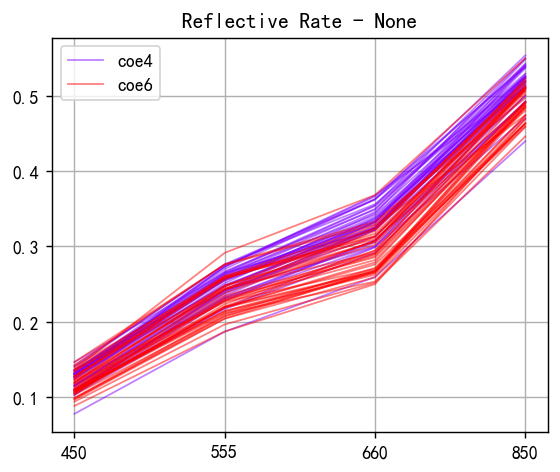

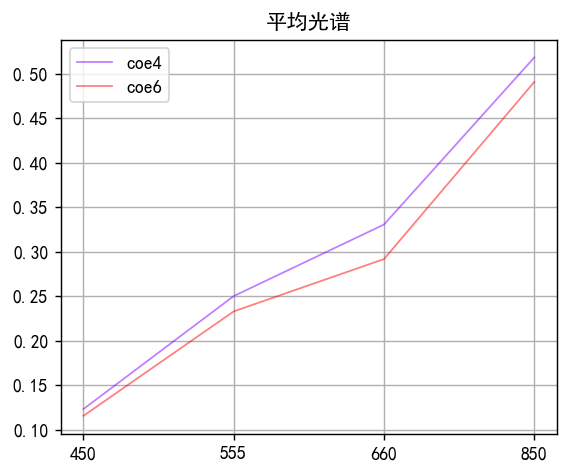

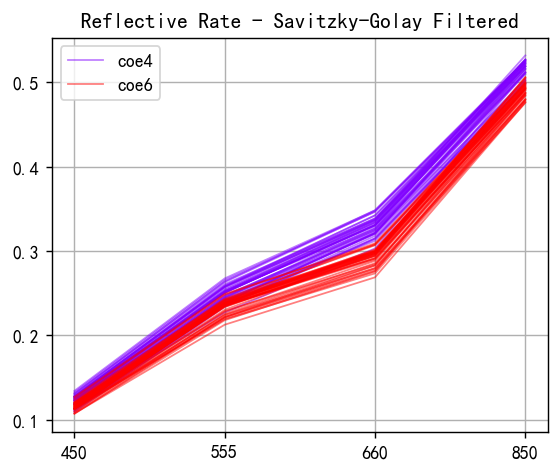

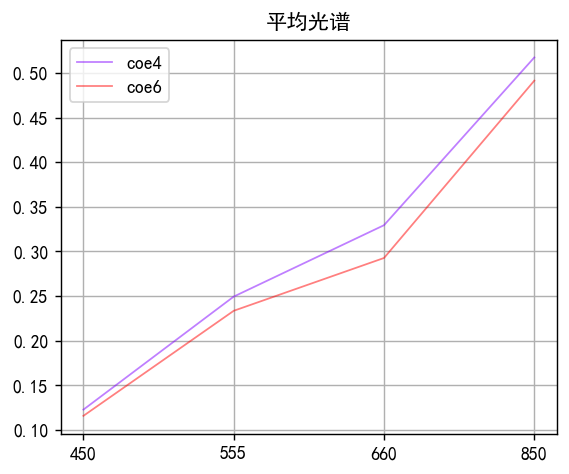

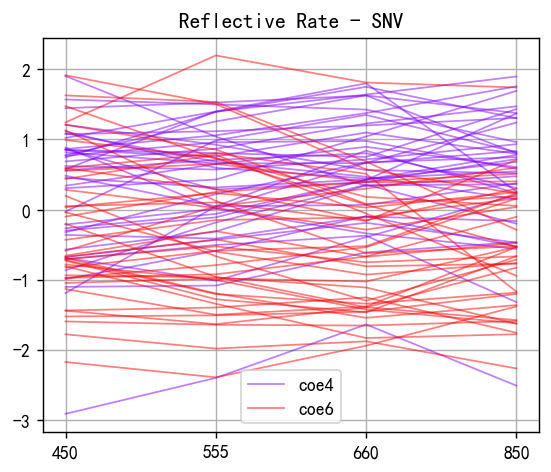

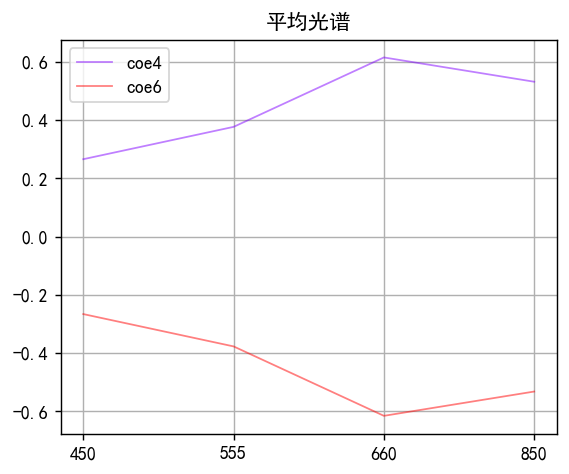

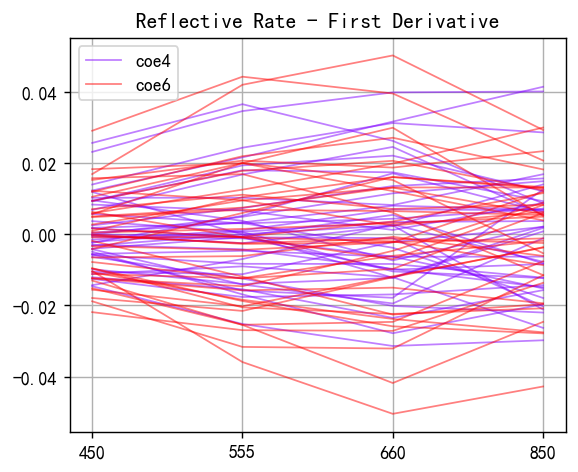

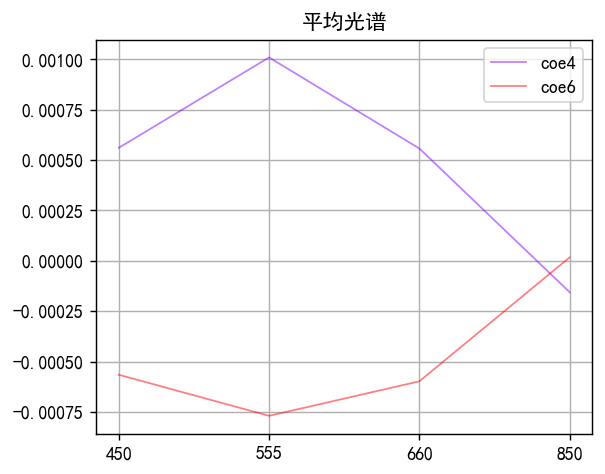

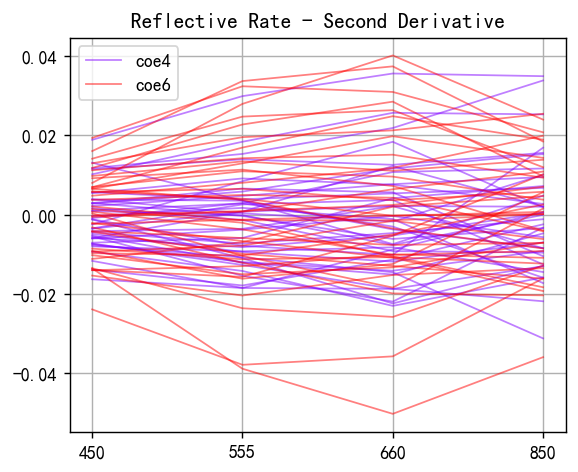

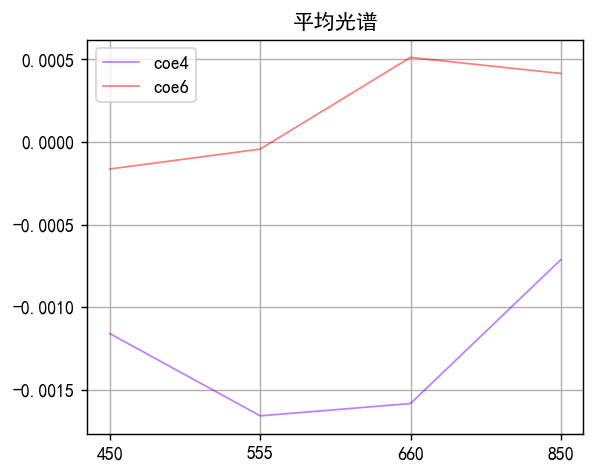

In [4]:
from gx_spectral.visualization import drawer
def spec_chart_display(specs, labels, title):
    spec_pos = [450, 555, 660, 850]
    spec_pos = np.array(spec_pos, dtype=str)
    img = drawer.show_specs_class(spec_pos, specs, labels, title=title)
    return

spec_chart_display(specs, labels, "Reflective Rate - None")
spec_chart_display(sg_specs, labels, "Reflective Rate - Savitzky-Golay Filtered")
spec_chart_display(snv_specs, labels, "Reflective Rate - SNV")
spec_chart_display(FD_specs, labels, "Reflective Rate - First Derivative")
spec_chart_display(SD_specs, labels, "Reflective Rate - Second Derivative")

## 三、建模分析
### 1. Prerequisite
定义一个网格搜索函数 `grid_search` 用于找到最佳参数

In [5]:
from sklearn.pipeline import Pipeline
def grid_search(X_train, y_train, savePath='./svm2'):
    tuned_parameters = [
    {"kernel": ["rbf", 'linear'], "gamma": 1/np.power(10, np.arange(5)), "C": np.power(10, np.arange(5))},]
    param_grid = {
        'pca__n_components': np.arange(2,5),
        'clf__C': np.power(10, np.arange(5)),
        'clf__gamma': 1/np.power(10, np.arange(5)),
        'clf__kernel': ["rbf", 'linear']
    }
    score = 'accuracy'
    # score = 'neg_mean_squared_error'
    # scaler = StandardScaler().fit(X_train)
    # X_scaled = scaler.transform(X_train)
    pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2)), ('clf', svm.SVC())])
    clf = GridSearchCV(pipeline, param_grid, scoring=score, cv=5)

    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Best score:",clf.best_score_)
    #保存最优参数
    paraFilePath = os.path.join(savePath, 'best_model_parameters.json')
#     with open(paraFilePath, 'w+') as f:
#         json.dump(clf.best_params_, f)

    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    return clf.best_estimator_


### 2. 取得带有 GLCM 的数据
使用 `np.concatenate` 拼接矩阵

In [6]:
specs_with_GLCM = np.concatenate((specs, glcm_features), axis = 1)
# snv_specs_with_GLCM = np.concatenate((snv_specs, glcm_features), axis = 1)
# FD_specs_with_GLCM = np.concatenate((FD_specs, glcm_features), axis = 1)
# SD_specs_with_GLCM = np.concatenate((SD_specs, glcm_features), axis = 1)

# Validate
print(specs_with_GLCM.shape)
# print(snv_specs_with_GLCM.shape)
# print(FD_specs_with_GLCM.shape)
# print(SD_specs_with_GLCM.shape)

(80, 292)


### 3.1 Train without GLCM by SVM

[0.5    0.5625 0.5    0.5625 0.5   ]
0.525
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1000, gamma=0.001, kernel='linear'))])
The train score of model is : 0.546875
The test score of model is : 0.562500


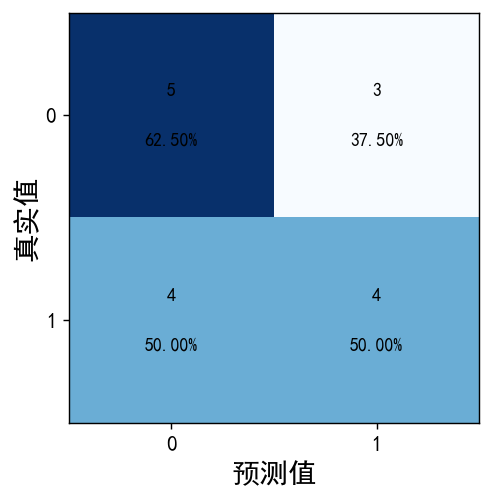

In [7]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from gx_spectral.visualization import drawer
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import preprocessing

# pca = PCA(n_components=3)
X = SD_specs
y = labels
strKFold = StratifiedKFold(n_splits=5, shuffle=False)
model = make_pipeline(
    StandardScaler(),
    # PCA(n_components=5),
    # RandomForestClassifier(),
    svm.SVC(kernel='linear', C=1000, gamma=0.001)
)

# 自动划分数据集进行建模评估
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)
# model = grid_search(X_train, y_train)
scores = cross_val_score(model,X,y,cv=strKFold)
print(scores)
print(scores.mean())


print(model)
model.fit(X_train,y_train)
score_res = model.score(X_train,y_train)
print("The train score of model is : %f"%score_res)
score_res = model.score(X_test,y_test)
print("The test score of model is : %f"%score_res)
y_pred = model.predict(X_test)
img, report = drawer.show_confusion_matrix(y_test, y_pred)
cv.imwrite('Plots/Prediction/prediction_None_SVM.png', img)
# 将report保存成本地文件
pd.DataFrame(report).transpose().to_csv("report_None_SVM.csv", index= True, float_format='%.2f')

### 3.2 Train with GLCM by SVM

[0.875 1.    1.    1.    1.   ]
0.975
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1000, gamma=0.001, kernel='linear'))])
The train score of model is : 1.000000
The test score of model is : 1.000000


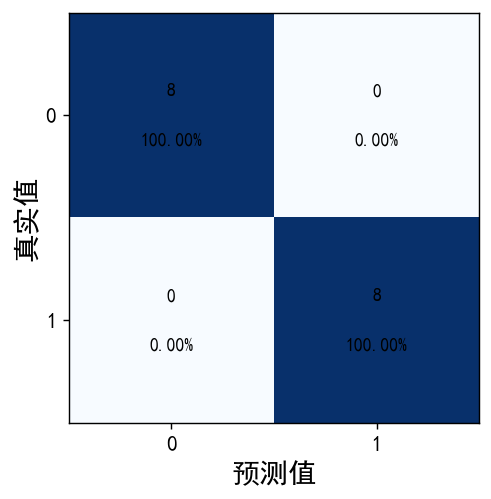

In [8]:
X = specs_with_GLCM
y = labels
strKFold = StratifiedKFold(n_splits=5, shuffle=False)
model = make_pipeline(
    StandardScaler(),
    # PCA(n_components=5),
    # RandomForestClassifier(),
    svm.SVC(kernel='linear', C=1000, gamma=0.001)
)

# 自动划分数据集进行建模评估
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)
# model = grid_search(X_train, y_train)
scores = cross_val_score(model,X,y,cv=strKFold)
print(scores)
print(scores.mean())


print(model)
model.fit(X_train,y_train)
score_res = model.score(X_train,y_train)
print("The train score of model is : %f"%score_res)
score_res = model.score(X_test,y_test)
print("The test score of model is : %f"%score_res)
y_pred = model.predict(X_test)
img, report = drawer.show_confusion_matrix(y_test, y_pred)
cv.imwrite('Plots/Prediction/prediction_GLCM_SVM.png', img)
# 将report保存成本地文件
pd.DataFrame(report).transpose().to_csv("report_GLCM_SVM.csv", index= True, float_format='%.2f')

### 4.1 Train without GLCM by KNN

[0.5   0.625 0.5   0.5   0.5  ]
0.525
最优的K值: 3
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])
The train score of model is : 0.765625
The test score of model is : 0.500000


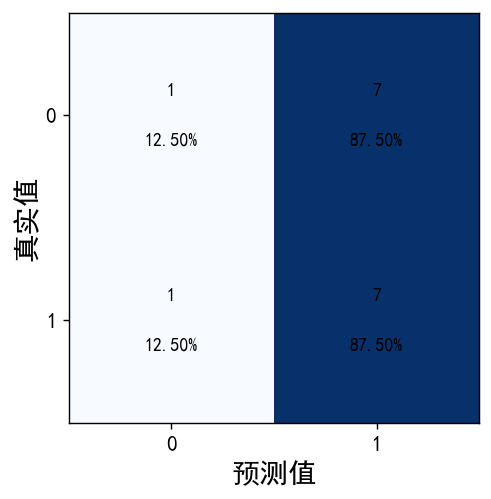

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

X = SD_specs
y = labels
strKFold = StratifiedKFold(n_splits=5, shuffle=False)
model = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

# 自动划分数据集进行建模评估
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)

scores = cross_val_score(model,X,y,cv=strKFold)
print(scores)
print(scores.mean())

# 使用 GridSearch 网格搜索得到最优 K 值
# 设置参数网络，检索（1, 20）内最佳的 k 参数
param_grid = {
    'kneighborsclassifier__n_neighbors': range(1, 20)
}

grid_search_KNN = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search_KNN.fit(X_train, y_train)

print(f"最优的K值: {grid_search_KNN.best_params_['kneighborsclassifier__n_neighbors']}")


print(model)
model.fit(X_train,y_train)
score_res = model.score(X_train,y_train)
print("The train score of model is : %f"%score_res)
score_res = model.score(X_test,y_test)
print("The test score of model is : %f"%score_res)
y_pred = model.predict(X_test)
img, report = drawer.show_confusion_matrix(y_test, y_pred)
cv.imwrite('Plots/Prediction/prediction_None_KNN.png', img)
# 将report保存成本地文件
pd.DataFrame(report).transpose().to_csv("report_None_KNN.csv", index= True, float_format='%.2f')

### 4.2 Train with GLCM by KNN

[0.6875 0.5    0.5    0.6875 0.5   ]
0.575
最优的K值: 7
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])
The train score of model is : 0.718750
The test score of model is : 0.500000


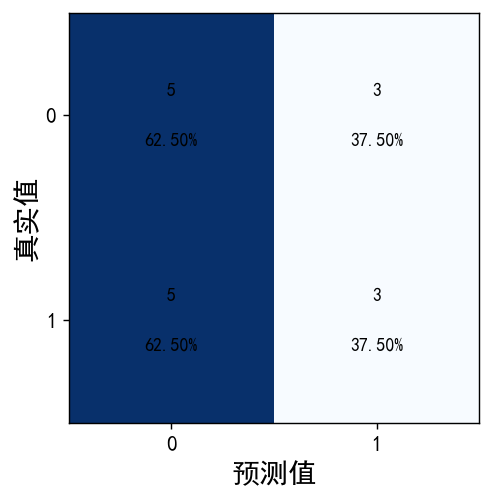

In [10]:
X = specs_with_GLCM
y = labels
strKFold = StratifiedKFold(n_splits=5, shuffle=False)
model = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

# 自动划分数据集进行建模评估
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)

scores = cross_val_score(model,X,y,cv=strKFold)
print(scores)
print(scores.mean())

# 使用 GridSearch 网格搜索得到最优 K 值
# 设置参数网络，检索（1, 20）内最佳的 k 参数
param_grid = {
    'kneighborsclassifier__n_neighbors': range(1, 20)
}

grid_search_KNN = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search_KNN.fit(X_train, y_train)

print(f"最优的K值: {grid_search_KNN.best_params_['kneighborsclassifier__n_neighbors']}")


print(model)
model.fit(X_train,y_train)
score_res = model.score(X_train,y_train)
print("The train score of model is : %f"%score_res)
score_res = model.score(X_test,y_test)
print("The test score of model is : %f"%score_res)
y_pred = model.predict(X_test)
img, report = drawer.show_confusion_matrix(y_test, y_pred)
cv.imwrite('Plots/Prediction/prediction_GLCM_KNN.png', img)
# 将 report 保存成本地文件
pd.DataFrame(report).transpose().to_csv("report_GLCM_KNN.csv", index= True, float_format='%.2f')

### 5.1 Train without GLCM by NB

[0.5625 0.625  0.5625 0.4375 0.6875]
0.575
Best parameter: {'gaussiannb__var_smoothing': 1e-09}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])
The train score of model is : 0.656250
The test score of model is : 0.437500


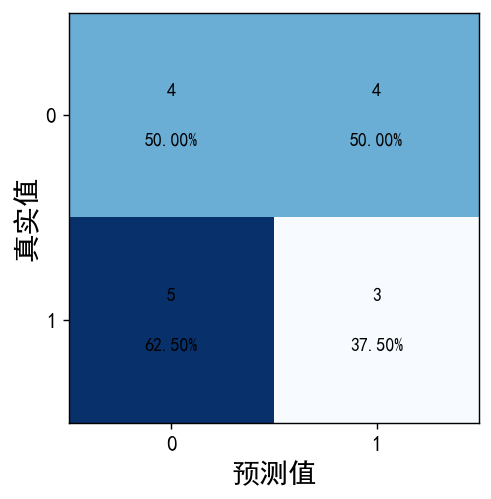

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

X = SD_specs
y = labels

strKFold = StratifiedKFold(n_splits=5, shuffle=False)
model = make_pipeline(
    StandardScaler(),
    GaussianNB()
)

# 自动划分数据集进行建模评估
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)
scores = cross_val_score(model,X,y,cv=strKFold)
print(scores)
print(scores.mean())
# 网格搜索参数
param_grid = {
    'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

grid_search_NB = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,                     # 5折交叉验证
    scoring='accuracy',       # 以准确率作为评估指标
    n_jobs=-1                  # 用所有CPU核加速
)

grid_search_NB.fit(X, y)

print(f"Best parameter: {grid_search_NB.best_params_}")

print(model)
model.fit(X_train,y_train)
score_res = model.score(X_train,y_train)
print("The train score of model is : %f"%score_res)
score_res = model.score(X_test,y_test)
print("The test score of model is : %f"%score_res)
y_pred = model.predict(X_test)
img, report = drawer.show_confusion_matrix(y_test, y_pred)
cv.imwrite('Plots/Prediction/prediction_None_NB.png', img)
# 将report保存成本地文件
pd.DataFrame(report).transpose().to_csv("report_None_NB.csv", index= True, float_format='%.2f')

### 5.2 Train with GLCM by NB


[0.5625 0.6875 0.5625 0.625  0.6875]
0.625
Best parameter: {'gaussiannb__var_smoothing': 1e-09}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])
The train score of model is : 0.687500
The test score of model is : 0.375000


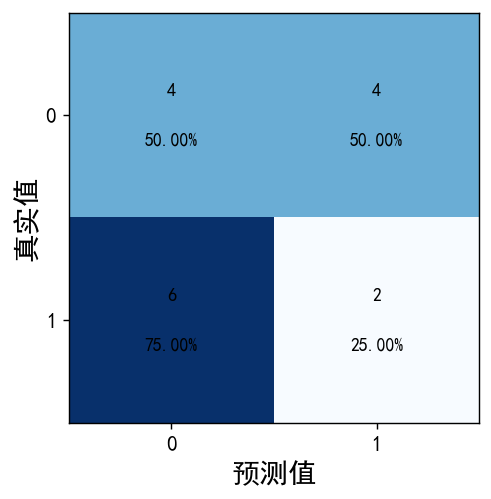

In [12]:
X = specs_with_GLCM
y = labels

strKFold = StratifiedKFold(n_splits=5, shuffle=False)
model = make_pipeline(
    StandardScaler(),
    GaussianNB()
)

# 自动划分数据集进行建模评估
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)
scores = cross_val_score(model,X,y,cv=strKFold)
print(scores)
print(scores.mean())
# 网格搜索参数
param_grid = {
    'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

grid_search_NB = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,                     # 5折交叉验证
    scoring='accuracy',       # 以准确率作为评估指标
    n_jobs=-1                  # 用所有CPU核加速
)

grid_search_NB.fit(X, y)

print(f"Best parameter: {grid_search_NB.best_params_}")

print(model)
model.fit(X_train,y_train)
score_res = model.score(X_train,y_train)
print("The train score of model is : %f"%score_res)
score_res = model.score(X_test,y_test)
print("The test score of model is : %f"%score_res)
y_pred = model.predict(X_test)
img, report = drawer.show_confusion_matrix(y_test, y_pred)
cv.imwrite('Plots/Prediction/prediction_GLCM_NB.png', img)
# 将report保存成本地文件
pd.DataFrame(report).transpose().to_csv("report_GLCM_NB.csv", index= True, float_format='%.2f')

### 6.1 Train without GLCM by Random Forest

[0.5    0.5625 0.375  0.5    0.375 ]
0.4625
Best parameter: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 200}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])
The train score of model is : 1.000000
The test score of model is : 0.562500


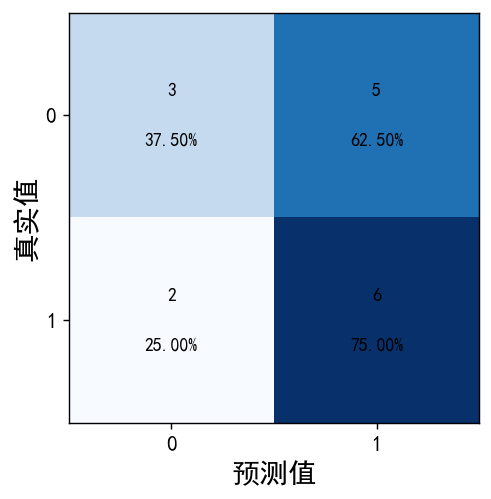

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

X = SD_specs
y = labels
strKFold = StratifiedKFold(n_splits=5, shuffle=False)
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
)


param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 200],       # 树的数量
    'randomforestclassifier__max_depth': [None],      # 树的最大深度 (None 表示不限制)
    'randomforestclassifier__min_samples_split': [2, 5, 10],      # 内部节点分裂所需的最小样本数
    'randomforestclassifier__min_samples_leaf': [1, 3, 5]         # 叶节点所需的最小样本数
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)
scores = cross_val_score(model,X,y,cv=strKFold)
print(scores)
print(scores.mean())

grid_search_RF = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search_RF.fit(X_train,y_train)

print(f"Best parameter: {grid_search_RF.best_params_}")

print(model)
model.fit(X_train,y_train)
score_res = model.score(X_train,y_train)
print("The train score of model is : %f"%score_res)
score_res = model.score(X_test,y_test)
print("The test score of model is : %f"%score_res)
y_pred = model.predict(X_test)
img, report = drawer.show_confusion_matrix(y_test, y_pred)
cv.imwrite('Plots/Prediction/prediction_None_RF.png', img)
# 将report保存成本地文件
pd.DataFrame(report).transpose().to_csv("report_None_RF.csv", index= True, float_format='%.2f')

### 6.2 Train with GLCM by Random Forest

[0.6875 1.     0.875  0.625  0.75  ]
0.7875
Best parameter: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 50}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])
The train score of model is : 1.000000
The test score of model is : 0.750000


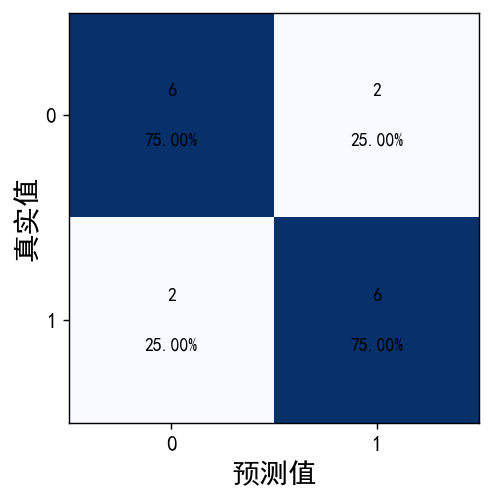

In [14]:
X = specs_with_GLCM
y = labels
strKFold = StratifiedKFold(n_splits=5, shuffle=False)
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
)


param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 200],       # 树的数量
    'randomforestclassifier__max_depth': [None],      # 树的最大深度 (None 表示不限制)
    'randomforestclassifier__min_samples_split': [2, 5, 10],      # 内部节点分裂所需的最小样本数
    'randomforestclassifier__min_samples_leaf': [1, 3, 5]         # 叶节点所需的最小样本数
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)
scores = cross_val_score(model,X,y,cv=strKFold)
print(scores)
print(scores.mean())

grid_search_RF = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search_RF.fit(X_train,y_train)

print(f"Best parameter: {grid_search_RF.best_params_}")

print(model)
model.fit(X_train,y_train)
score_res = model.score(X_train,y_train)
print("The train score of model is : %f"%score_res)
score_res = model.score(X_test,y_test)
print("The test score of model is : %f"%score_res)
y_pred = model.predict(X_test)
img, report = drawer.show_confusion_matrix(y_test, y_pred)
cv.imwrite('Plots/Prediction/prediction_GLCM_RF.png', img)
# 将report保存成本地文件
pd.DataFrame(report).transpose().to_csv("report_GLCM_RF.csv", index= True, float_format='%.2f')